In [ ]:
import os
import math
from pathlib import Path
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

from utils import load_data, plot_history_tf, plot_heat_map

In [5]:
# -------------------------
# Configuration
# -------------------------
IMG_SIZE = 224  # image height/width in pixels (square)
IMAGE_DIR = Path("./ecg_images")
NPY_IMAGE_DIR = Path("./ecg_images_npy")
NPY_SIGNAL_DIR = Path("./ecg_signals_npy")
MODEL_SAVE_PATH = Path("./ecg_hybrid_model.h5")

BATCH_SIZE = 32
EPOCHS = 50
RANDOM_SEED = 42
NUM_CLASSES = 15

# Create directories
IMAGE_DIR.mkdir(parents=True, exist_ok=True)
NPY_IMAGE_DIR.mkdir(parents=True, exist_ok=True)
NPY_SIGNAL_DIR.mkdir(parents=True, exist_ok=True)

In [10]:
# -------------------------
# Part A: Processing 1D -> 2D images
# -------------------------
def normalize_signal(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32)
    # standard score normalization (per-sample)
    mean = x.mean()
    std = x.std() if x.std() > 1e-6 else 1.0
    return (x - mean) / std


def signal_to_image(signal: np.ndarray, out_path: Path, img_size: int = IMG_SIZE):
    """Render a single 1D ECG signal to a square grayscale PNG of size (img_size, img_size).
    We draw waveform with margins and no axes, then save as 224x224 grayscale PNG.
    """
    plt.figure(figsize=(img_size / 100, img_size / 100), dpi=100)
    ax = plt.axes([0, 0, 1, 1])  # fill the figure
    ax.set_axis_off()

    # normalize between -1 and 1 for plotting
    s = signal.astype(np.float32)
    s = (s - s.min()) / (s.max() - s.min() + 1e-8)  # 0..1
    s = s * 2 - 1  # -1..1

    x = np.linspace(0, 1, len(s))
    ax.plot(x, s, color='black', linewidth=1.2)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)

    # save
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close()

    # optionally resize via PIL to ensure exact size
    from PIL import Image
    im = Image.open(out_path).convert('L')
    im = im.resize((img_size, img_size), resample=Image.BICUBIC)
    im.save(out_path)


def create_image_dataset_from_signals(X: np.ndarray, y: np.ndarray, force_regen: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Create image files for each 1D segment. Also save image arrays (npys) for fast training.
    Returns (image_paths_array, labels_array) where image_paths_array is a list of file paths.
    """
    image_paths = []
    labels = []

    for i in tqdm(range(len(X)), desc="Signals -> Images"):
        label = int(y[i])
        class_dir = IMAGE_DIR / str(label)
        class_dir.mkdir(parents=True, exist_ok=True)
        fname = f"sig_{i:06d}_lbl{label}.png"
        out_path = class_dir / fname
        if (not out_path.exists()) or force_regen:
            # normalize & render
            s = normalize_signal(X[i])
            signal_to_image(s, out_path, IMG_SIZE)

        # save a fast numpy array as well
        img = plt.imread(out_path)
        img_arr = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
        npy_path = NPY_IMAGE_DIR / f"sig_{i:06d}_lbl{label}.npy"
        np.save(npy_path, img_arr)

        image_paths.append(str(npy_path))
        labels.append(label)

    return np.array(image_paths), np.array(labels)

In [7]:
# -------------------------
# Data loader: pairs of (signal, image) -> label
# -------------------------

def load_pair_dataset(signal_npy: np.ndarray, image_npy_paths: np.ndarray, labels: np.ndarray, batch_size: int, shuffle: bool = True):
    """Create tf.data.Dataset yielding ((signal, image), label)
    signal_npy: np.ndarray of signals (N, 300)
    image_npy_paths: array of paths to image .npy files (N,)
    labels: (N,)
    """
    def generator():
        for sig, img_path, lbl in zip(signal_npy, image_npy_paths, labels):
            img = np.load(img_path)
            # ensure shape HxW or HxWxC
            if img.ndim == 2:
                img = img[..., None]
            # normalize image to 0..1 float32
            img = img.astype(np.float32) / 255.0
            # normalize signal per-sample
            sig = normalize_signal(sig)
            yield (sig, img), lbl

    output_signature = ((tf.TensorSpec(shape=(signal_npy.shape[1],), dtype=tf.float32),
                         tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32)),
                        tf.TensorSpec(shape=(), dtype=tf.int32))

    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    if shuffle:
        ds = ds.shuffle(buffer_size=1024, seed=RANDOM_SEED)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [8]:
# -------------------------
# Model: 1D branch and 2D branch
# -------------------------

def build_1d_branch(input_shape=(300,)):
    inp = layers.Input(shape=input_shape, name="ecg_signal")
    x = layers.Reshape((input_shape[0], 1))(inp)

    # Conv blocks
    for filters, k, pool in [(32, 7, 2), (64, 5, 2), (128, 5, None), (256, 3, None)]:
        x = layers.Conv1D(filters, kernel_size=k, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        if pool:
            x = layers.MaxPool1D(pool_size=pool)(x)
        x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    model = models.Model(inputs=inp, outputs=x, name='1d_branch')
    return model


def conv2d_block(x, filters, kernel_size=3, pool=True):
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if pool:
        x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Dropout(0.25)(x)
    return x


def build_2d_branch(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inp = layers.Input(shape=input_shape, name='ecg_image')
    x = inp
    for f in [32, 64, 128]:
        x = conv2d_block(x, f, kernel_size=3, pool=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    model = models.Model(inputs=inp, outputs=x, name='2d_branch')
    return model


def build_hybrid_model(signal_shape=(300,), image_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=NUM_CLASSES):
    branch1 = build_1d_branch(signal_shape)
    branch2 = build_2d_branch(image_shape)

    # combined
    combined = layers.concatenate([branch1.output, branch2.output])
    x = layers.Dense(256, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    out = layers.Dense(num_classes, activation='softmax', name='output')(x)

    model = models.Model(inputs=[branch1.input, branch2.input], outputs=out, name='ecg_hybrid')
    return model

In [9]:
# -------------------------
# Training utility
# -------------------------

def train_hybrid(X_train, X_val, y_train, y_val, image_paths_train, image_paths_val):
    train_ds = load_pair_dataset(X_train, image_paths_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
    val_ds = load_pair_dataset(X_val, image_paths_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

    model = build_hybrid_model()
    opt = optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.02),
                  metrics=['accuracy'])

    model.summary()

    cb = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
        callbacks.ModelCheckpoint(str(MODEL_SAVE_PATH), monitor='val_accuracy', save_best_only=True),
        callbacks.TensorBoard(log_dir='./logs')
    ]

    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)

    # evaluate
    # build arrays for evaluation
    y_pred = []
    y_true = []
    for (sig_batch, img_batch), lbl_batch in val_ds:
        preds = model.predict([sig_batch, img_batch])
        y_pred.extend(np.argmax(preds, axis=-1).tolist())
        y_true.extend(lbl_batch.numpy().tolist())

    plot_heat_map(np.array(y_true), np.array(y_pred))
    plot_history_tf(history)

    return model, history


loading the ecg data of No.100
loading the ecg data of No.101
loading the ecg data of No.103
loading the ecg data of No.105
loading the ecg data of No.106
loading the ecg data of No.107
loading the ecg data of No.108
loading the ecg data of No.109
loading the ecg data of No.111
loading the ecg data of No.112
loading the ecg data of No.113
loading the ecg data of No.114
loading the ecg data of No.115
loading the ecg data of No.116
loading the ecg data of No.117
loading the ecg data of No.119
loading the ecg data of No.121
loading the ecg data of No.122
loading the ecg data of No.123
loading the ecg data of No.124
loading the ecg data of No.200
loading the ecg data of No.201
loading the ecg data of No.202
loading the ecg data of No.203
loading the ecg data of No.205
loading the ecg data of No.208
loading the ecg data of No.210
loading the ecg data of No.212
loading the ecg data of No.213
loading the ecg data of No.214
loading the ecg data of No.215
loading the ecg data of No.217
loading 

Signals -> Images:   9%|▉         | 6981/77872 [08:12<1:23:25, 14.16it/s] 


KeyboardInterrupt: 

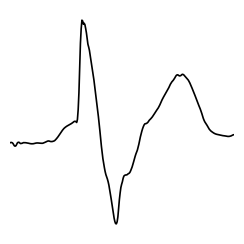

In [11]:
# -------------------------
# Main script: orchestrate processing + training
# -------------------------
if __name__ == '__main__':
    # 1) Load 1D data using provided utils
    X_train, X_test, y_train, y_test = load_data(0.2, RANDOM_SEED)

    # save raw signals for reproducibility
    np.save(NPY_SIGNAL_DIR / 'X_train_signals.npy', X_train)
    np.save(NPY_SIGNAL_DIR / 'X_test_signals.npy', X_test)
    np.save(NPY_SIGNAL_DIR / 'y_train.npy', y_train)
    np.save(NPY_SIGNAL_DIR / 'y_test.npy', y_test)

    # 2) Create images for the train + test sets (images saved as .npy fast loaders)
    train_image_paths, train_labels_img = create_image_dataset_from_signals(X_train, y_train)
    test_image_paths, test_labels_img = create_image_dataset_from_signals(X_test, y_test)

    # Sanity: ensure labels align
    assert np.array_equal(train_labels_img, y_train), "Train labels mismatch between signals and images"
    assert np.array_equal(test_labels_img, y_test), "Test labels mismatch between signals and images"

    # 3) Train hybrid model
    model, history = train_hybrid(X_train, X_test, y_train, y_test, train_image_paths, test_image_paths)

    print("Training finished. Best model saved to:", MODEL_SAVE_PATH)